In [10]:
import numpy as np
import pandas as pd

In [11]:
# From https://github.com/kratzert/pangeo_lstm_example/blob/master/LSTM_for_rainfall_runoff_modelling.ipynb
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

In [ ]:
# Read all input txt files
import glob

path = '../Input files (.txt)'
all_files = glob.glob(path + "/*.txt")

df_dict = {}
for file_path in all_files:
    print(f'Reading file: {file_path}')
    # Name is formatted `./Input files (.txt)/nve_inp_XX.txt`
    number = int(file_path.split('_')[-1].split('.')[0])

    df = pd.read_csv(file_path, encoding='cp1252', skiprows=[0], delimiter=r"\s+", parse_dates=[['dd.mm.yyyy',  'hh:mm:ss']])
    df = df.rename(columns={"dd.mm.yyyy_hh:mm:ss": "timestamp"})
    df_dict[number] = df


Reading file: ../Input files (.txt)/nve_inp_90.txt
Reading file: ../Input files (.txt)/nve_inp_56.txt


In [9]:
# All files have equal values for grC and grC.1
for df in df_dict.values():
    print(df['grC'].equals(df['grC.1']))

In [5]:
print(df_dict[1].keys())
n_without_gaps = 0
without_gaps = {}
for n in df_dict:
    df = df_dict[n]
    df1 = df.sort_values('timestamp').apply(lambda x: x.diff().max()).reset_index(name='max_diff')
    display(df1)
    if df1['max_diff'][0].days < 2:
        print('Without gap')
        n_without_gaps += 1
        without_gaps[n] = df

print(f'Number of timeseries without gaps: {n_without_gaps}')

KeyError: 1

In [43]:
# Catchments without measurement gaps
for id in sorted(without_gaps.keys()):
    df = without_gaps[id]
    # print(df)
    _min = df['timestamp'].min()
    _max = df['timestamp'].max()
    _diff = _max - _min
    print(f"{id} {_min} {_max} {_diff}")

1 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
4 2005-01-01 00:00:00 2015-12-31 00:00:00 4016 days 00:00:00
6 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
9 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
11 2002-12-24 00:00:00 2015-12-31 00:00:00 4755 days 00:00:00
14 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
18 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
25 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
30 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
34 2006-01-01 00:00:00 2015-12-31 00:00:00 3651 days 00:00:00
38 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
44 2000-01-01 00:00:00 2015-12-31 00:00:00 5843 days 00:00:00
46 2004-01-01 00:00:00 2015-12-31 00:00:00 4382 days 00:00:00
47 2008-01-01 00:00:00 2015-12-31 00:00:00 2921 days 00:00:00
51 2007-01-01 00:00:00 2015-12-31 00:00:00 3286 days 00:00:00
56 2003-12-19 00:00:00 2015-12-31 00:00:00 4395 days 00:00:00
65 2000-01-0

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def plot_multi_histogram(catchments):
    # plot with various axes scales
    
    plt.figure(figsize=(5, 5))

    all_nses = []
    max_y = None
    for offset in range(12):
        plt.subplot(4,4,offset+1)
        offset += 1
        nses = []
        all_nses.append(nses)
        # Calculate nse based on model which predicts the previous day for all timeseries without gaps
        for id in sorted(catchments.keys()):
            runoff = catchments[id]['m3/s'].to_numpy()
            offset = offset
            nse = calc_nse(runoff[offset:], runoff[:-offset])
            nses.append(nse)
            # print(f'{id:02d}, nse: {nse:.3f}')

        # the histogram of the data
        n, bins, patches = plt.hist(all_nses[-1], bins=[0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'{offset} days')
        if max_y is None:
            max_y = max(n)
        plt.ylim(top=max_y, bottom=0)

    plt.show()



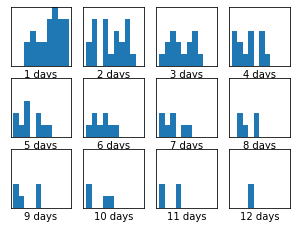

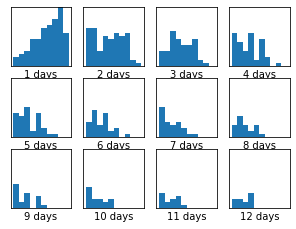

In [41]:
plot_multi_histogram(without_gaps)
plot_multi_histogram(df_dict)

In [44]:
# Use k nearest neighbour for catchments without measurement gaps

from sklearn.model_selection import train_test_split

In [ ]:
def generate_training_test(df, )